In [1]:
# if you do not like to install it
# import sys
# sys.path.insert(0,'../')

# DATA

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
from os import path
from glob import glob
from tqdm import tqdm
# from skimage.io import imread
from skimage.transform import resize
from scipy.spatial import distance_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.keras import TqdmCallback
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import tfcook as tfc

In [4]:
image_size = 32

if path.exists("data.npz"):
    data = np.load('data.npz')
    x = data['x']
    y = data['y']
    n_class = len(np.unique(y))
else:
    import tensorflow_datasets as tfds
    ds = tfds.load('RockPaperScissors', split='train', shuffle_files=True)
    elms = []
    ii = 0
    for element in ds.as_numpy_iterator(): 
        elms.append(element) 
    #     if ii>10: break
    x = []
    y = []
    for i in range(len(elms)):
        x.append(elms[i]['image'])
        y.append(elms[i]['label'])
    x = np.array(x)
    y = np.array(y)
    xp = []
    for xi in x:
        xp.append(resize(xi,(image_size,image_size),preserve_range=1))
    x = np.array(xp)

    x = x.astype(np.float32)/255
    y = y.astype(int)

    labels = np.unique(y)
    n_class = len(labels)
    labelmap = {j:i for i,j in enumerate(labels)}
    y = [labelmap[i] for i in y]
    y = np.array(y)
    np.savez('data',x=x,y=y)


In [5]:
labels = np.unique(y)
n_class = len(labels)
labelmap = {j:i for i,j in enumerate(labels)}
y = [labelmap[i] for i in y]
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.95,random_state=42)

print(x.shape,y.shape,x_test.shape,y_test.shape,x_train.shape,y_train.shape)

image_size = x.shape[1]

x.shape,y.shape

(2520, 32, 32, 3) (2520,) (2394, 32, 32, 3) (2394,) (126, 32, 32, 3) (126,)


((2520, 32, 32, 3), (2520,))

Text(0.5, 1.0, '0')

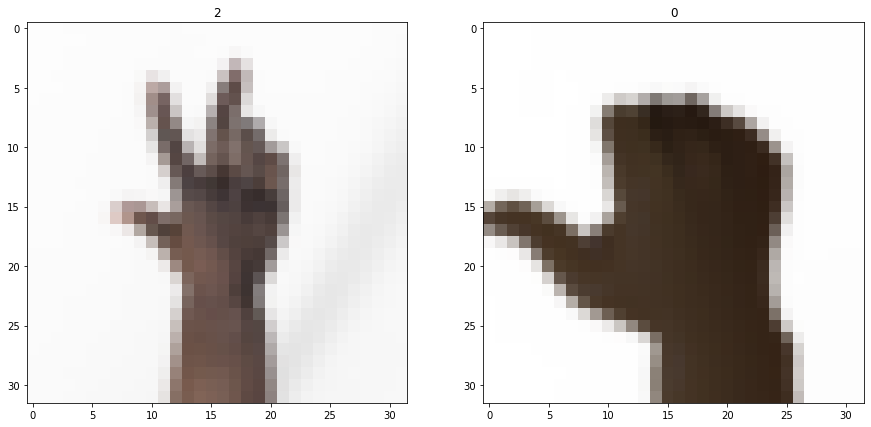

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ii = np.random.randint(x.shape[0])
ax1.imshow(x[ii])
ax1.set_title(y[ii])
ii = np.random.randint(x.shape[0])
ax2.imshow(x[ii])
ax2.set_title(y[ii])

In [7]:
image_channels = x.shape[3]

n_latent = image_size

# # Algorithm hyperparameters
num_epochs = 50

In [8]:
batch_size = 128
classification_augmentation = {'input_shape':(image_size, image_size, image_channels),"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

labeled_train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                            .shuffle(buffer_size=10 * batch_size)
                            .batch(batch_size)
                        )

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                  .shuffle(buffer_size=10 * batch_size)
                  .batch(batch_size)
                )

labeled_dataset_size = y_train.shape[0]

# SimCLR

In [14]:
encoder2 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

batch_size_simclr = 512

encoder2 = tfc.simclr_wartmup(encoder2,x,batch_size_simclr,num_epochs)

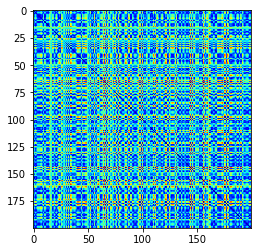

In [18]:
embeded_img = encoder2(x[:200]).numpy()

dists = distance_matrix(embeded_img,embeded_img)
plt.imshow(dists,cmap='jet')

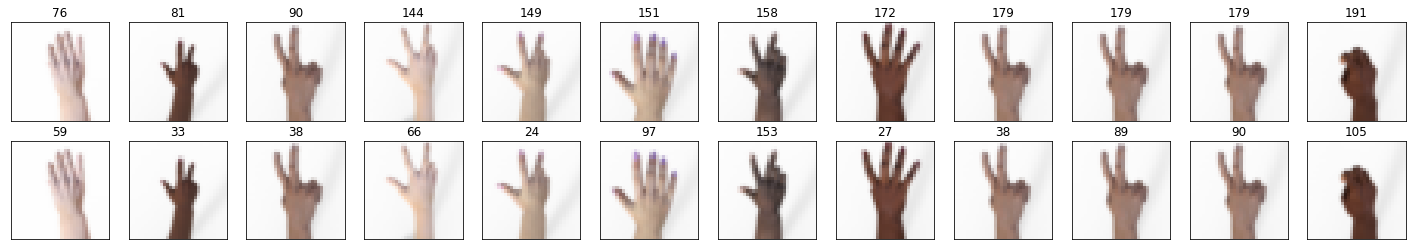

In [32]:
arr = dists
x1 =np.repeat(np.arange(arr.shape[0]), len(arr.flatten())/len(np.arange(arr.shape[0])))
x2 =np.tile(np.arange(arr.shape[1]), int(len(arr.flatten())/len(np.arange(arr.shape[1]))))
x3= arr.flatten()

df_dist = pd.DataFrame(np.array([x1,x2,x3]).T, columns=['p1','p2','dist'])
filt = df_dist['p1']>df_dist['p2']
df_dist = df_dist[filt]

rinds = []

filt = df_dist['dist']<df_dist['dist'].sort_values().values[12]

inds = np.argwhere(filt.values).reshape(-1)

n = len(inds)
plt.figure(figsize=(25, 4))
for i in range(1, n + 1):
    dd = df_dist.iloc[inds[i-1]]
    p1 = int(dd['p1'])
    p2 = int(dd['p2'])
    # print(p1,p2)
    rinds.append([p1,p2])
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x[p1])
    plt.title(p1)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x[p2])
    plt.title(p2)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Barlow Twins

In [21]:
encoder3 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

In [22]:
batch_size_bt = 128

encoder3 = tfc.barlow_twins_wartmup(encoder3,x,batch_size_bt,num_epochs)

0epoch [00:00, ?epoch/s]

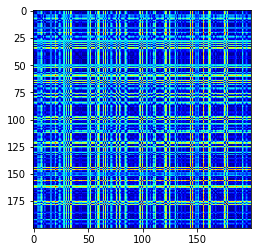

In [24]:
embeded_img = encoder3(x[:200]).numpy()

dists = distance_matrix(embeded_img,embeded_img)
plt.imshow(dists,cmap='jet')

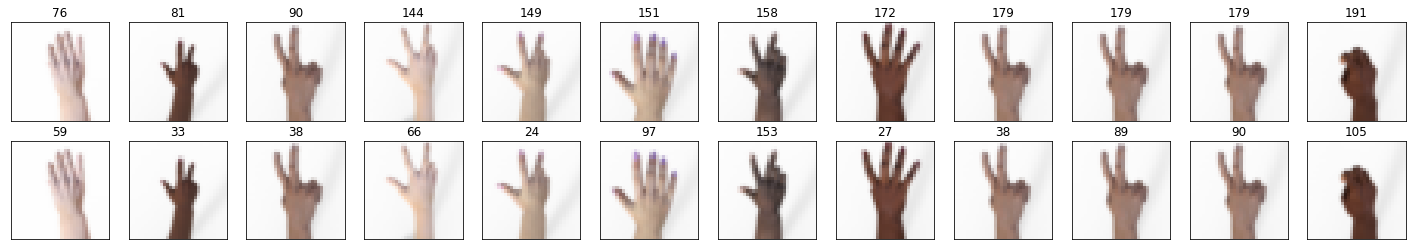

In [33]:
arr = dists
x1 =np.repeat(np.arange(arr.shape[0]), len(arr.flatten())/len(np.arange(arr.shape[0])))
x2 =np.tile(np.arange(arr.shape[1]), int(len(arr.flatten())/len(np.arange(arr.shape[1]))))
x3= arr.flatten()

df_dist = pd.DataFrame(np.array([x1,x2,x3]).T, columns=['p1','p2','dist'])
filt = df_dist['p1']>df_dist['p2']
df_dist = df_dist[filt]

rinds = []

filt = df_dist['dist']<df_dist['dist'].sort_values().values[12]

inds = np.argwhere(filt.values).reshape(-1)

n = len(inds)
plt.figure(figsize=(25, 4))
for i in range(1, n + 1):
    dd = df_dist.iloc[inds[i-1]]
    p1 = int(dd['p1'])
    p2 = int(dd['p2'])
    # print(p1,p2)
    rinds.append([p1,p2])
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x[p1])
    plt.title(p1)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x[p2])
    plt.title(p2)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### BYOL

In [26]:
encoder4 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

batch_size_byol = 128

encoder4 = tfc.byol_warmup(encoder4,x,batch_size_byol,num_epochs)

  0%|          | 0/2850 [00:00<?, ?it/s]

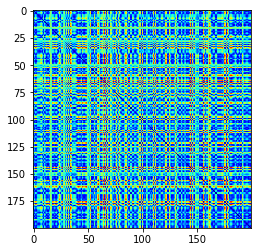

In [27]:
embeded_img = encoder4(x[:200]).numpy()

dists = distance_matrix(embeded_img,embeded_img)
plt.imshow(dists,cmap='jet')

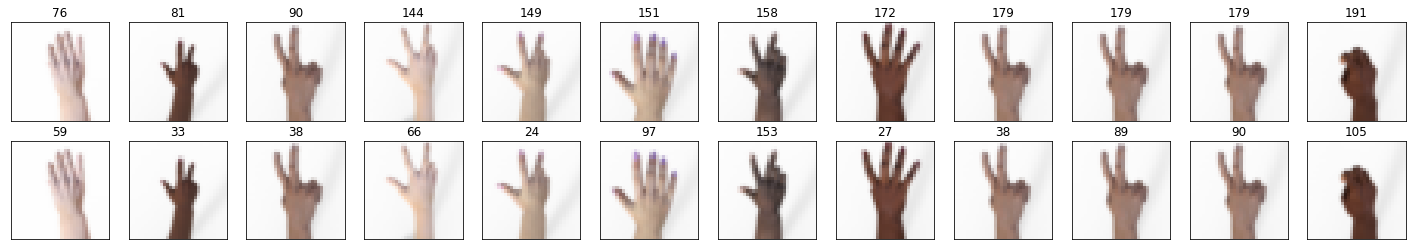

In [34]:
arr = dists
x1 =np.repeat(np.arange(arr.shape[0]), len(arr.flatten())/len(np.arange(arr.shape[0])))
x2 =np.tile(np.arange(arr.shape[1]), int(len(arr.flatten())/len(np.arange(arr.shape[1]))))
x3= arr.flatten()

df_dist = pd.DataFrame(np.array([x1,x2,x3]).T, columns=['p1','p2','dist'])
filt = df_dist['p1']>df_dist['p2']
df_dist = df_dist[filt]

rinds = []

filt = df_dist['dist']<df_dist['dist'].sort_values().values[12]

inds = np.argwhere(filt.values).reshape(-1)

n = len(inds)
plt.figure(figsize=(25, 4))
for i in range(1, n + 1):
    dd = df_dist.iloc[inds[i-1]]
    p1 = int(dd['p1'])
    p2 = int(dd['p2'])
    # print(p1,p2)
    rinds.append([p1,p2])
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x[p1])
    plt.title(p1)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x[p2])
    plt.title(p2)
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)